Cell 1 — Install specific versions

In [ ]:
# Cell 1: Install specific versions (run once)
!pip install pytorch-lightning==2.4.0 pytorch-forecasting==1.4.0 --quiet


Cell 2 — Load & clean

In [ ]:
# Cell 2: Load, clean, feature engineering, and create per-city time_idx
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

DATA_PATH = "/content/sample_data/dengue data 17-07-2025.csv"  # adjust if necessary
assert os.path.exists(DATA_PATH), f"Data file not found at {DATA_PATH}"

df = pd.read_csv(DATA_PATH)
df['week_start_date'] = pd.to_datetime(df['week_start_date'])
df = df.sort_values('week_start_date').reset_index(drop=True)

# Fill missing values
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

# Date features
df['month'] = df['week_start_date'].dt.month
df['day'] = df['week_start_date'].dt.day
df['dayofweek'] = df['week_start_date'].dt.dayofweek
df['year'] = df['week_start_date'].dt.year

# Keep original city name and create integer code (preserve mapping)
df['city_orig'] = df['city'].astype(str)
cat = df['city_orig'].astype('category')
city_id_to_name = {int(i): name for i, name in enumerate(cat.cat.categories)}
df['city'] = cat.cat.codes.astype(int)

# Basic outlier removal on total_cases (optional)
if 'total_cases' not in df.columns:
    raise KeyError("CSV must contain 'total_cases' column.")
Q1, Q3 = df["total_cases"].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
df = df[(df["total_cases"] >= lower) & (df["total_cases"] <= upper)].reset_index(drop=True)

# Assign time_idx per city (0..N-1 per city) — required for per-city TimeSeriesDataSet
parts = []
for city, g in df.groupby('city'):
    g = g.sort_values('week_start_date').reset_index(drop=True)
    g['time_idx'] = np.arange(len(g))
    parts.append(g)
df = pd.concat(parts).reset_index(drop=True)

print("Loaded rows:", len(df))
print("Cities found (id -> name):", city_id_to_name)
print("Rows per city:")
for city, g in df.groupby('city'):
    print(f"  {city} ({city_id_to_name.get(city)}): {len(g)} rows")


Cell 3 — Per-city train/test split (before modeling)

In [ ]:
# Cell 3: Per-city split (done BEFORE model creation)
TRAIN_FRACTION = 0.8  # set to 0.6 if you prefer 60/40

city_splits = {}
for city, g in df.groupby('city'):
    g = g.sort_values('time_idx').reset_index(drop=True)
    split_idx = int(len(g) * TRAIN_FRACTION)
    train_city = g.iloc[:split_idx].reset_index(drop=True)
    test_city  = g.iloc[split_idx:].reset_index(drop=True)
    city_splits[int(city)] = {'train': train_city, 'test': test_city}

# combined train/test (left for compatibility)
train_df = pd.concat([v['train'] for v in city_splits.values()]).reset_index(drop=True)
test_df  = pd.concat([v['test'] for v in city_splits.values()]).reset_index(drop=True)

for city, v in city_splits.items():
    print(f"City {city} ({city_id_to_name.get(city)}): train={len(v['train'])}, test={len(v['test'])}")

print("Combined train:", len(train_df), "combined test:", len(test_df))


Cell 4 — Dataset builder (dynamic encoder/pred lengths; dataloader checks

In [ ]:
# Cell 4: Make TimeSeriesDataSet and dataloaders for a given city (dynamic lengths)
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import GroupNormalizer
from pytorch_lightning import seed_everything

seed_everything(42)

# feature list - keep only features present in your CSV
features = [
    'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
    'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_tdtr_k',
    'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
    'station_min_temp_c', 'station_precip_mm',
    'month', 'day', 'dayofweek', 'year'
]
features = [f for f in features if f in df.columns]  # keep only cols present

target = 'total_cases'
DEFAULT_MAX_ENCODER = 24
DEFAULT_MAX_PRED = 8
BATCH_SIZE = 64

def make_datasets_for_city(city_id,
                           max_encoder_length=None,
                           max_prediction_length=None,
                           batch_size=BATCH_SIZE):
    if city_id not in city_splits:
        raise KeyError(f"Unknown city id {city_id}")
    train_city = city_splits[city_id]['train']
    test_city  = city_splits[city_id]['test']

    # adapt lengths to city history so we don't end up with zero subsequences
    history_len = len(train_city)
    max_enc = max(6, min(history_len - 1, max_encoder_length or DEFAULT_MAX_ENCODER))
    max_pred = max(1, min(12, max_prediction_length or DEFAULT_MAX_PRED))  # limit pred length
    # If history is very short, shrink encoder more:
    if history_len < (max_enc + max_pred):
        # reduce encoder so that at least one subsequence possible
        max_enc = max(6, history_len - max_pred)

    time_varying_known = ["time_idx"] + [c for c in features if c in train_city.columns]

    training = TimeSeriesDataSet(
        train_city,
        time_idx="time_idx",
        target=target,
        group_ids=["city"],
        min_encoder_length=max(1, max_enc // 2),
        max_encoder_length=max_enc,
        max_prediction_length=max_pred,
        time_varying_known_reals=time_varying_known,
        time_varying_unknown_reals=[target],
        target_normalizer=GroupNormalizer(groups=["city"]),
        allow_missing_timesteps=True,
    )

    validation = TimeSeriesDataSet.from_dataset(training, test_city, stop_randomization=True)

    train_dl = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dl   = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

    # debug info
    print(f"City {city_id} ({city_id_to_name.get(city_id)}): history_len={history_len}, encoder={max_enc}, pred={max_pred}")
    print(f"  subsequences -> train: {len(train_dl.dataset)}, val: {len(val_dl.dataset)}")
    return training, validation, train_dl, val_dl

# Quick test for first city
_example_city = list(city_splits.keys())[0]
_ = make_datasets_for_city(_example_city)


Cell 5 — Train helper (train per city, with checks & checkpoint)

In [ ]:
# Cell 5: Train function for a single city (saves best checkpoint)
import os, glob
import lightning.pytorch as L
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss

torch.set_float32_matmul_precision("medium")

def train_tft_for_city(city_id, max_epochs=30, hidden_size=64, attention_head_size=4, learning_rate=0.005):
    training_ds, validation_ds, train_dl, val_dl = make_datasets_for_city(city_id)
    if len(train_dl.dataset) == 0:
        raise RuntimeError(f"City {city_id} train dataloader has 0 subsequences. Reduce encoder length or get more historical data.")
    if len(val_dl.dataset) == 0:
        raise RuntimeError(f"City {city_id} val dataloader has 0 subsequences. Reduce encoder/pred length or ensure test split has enough rows.")

    # callbacks & checkpoint dir
    ckpt_dir = f"models/city_{city_id}"
    os.makedirs(ckpt_dir, exist_ok=True)
    checkpoint_callback = ModelCheckpoint(
        dirpath=ckpt_dir,
        filename="tft-city{city_id}-{epoch:02d}-{val_loss:.4f}",
        monitor="val_loss",
        save_top_k=1,
        mode="min",
    )
    early_stop = EarlyStopping(monitor="val_loss", patience=8, mode="min")
    lr_logger = LearningRateMonitor(logging_interval="epoch")

    trainer = L.Trainer(
        max_epochs=max_epochs,
        gradient_clip_val=0.1,
        callbacks=[checkpoint_callback, early_stop, lr_logger],
        accelerator="auto",
        devices=1 if torch.cuda.is_available() else None,
        enable_progress_bar=True,
        logger=True,
    )

    tft = TemporalFusionTransformer.from_dataset(
        training_ds,
        learning_rate=learning_rate,
        hidden_size=hidden_size,
        attention_head_size=attention_head_size,
        dropout=0.1,
        hidden_continuous_size=hidden_size,
        output_size=7,
        loss=QuantileLoss(),
        log_interval=10,
        reduce_on_plateau_patience=4,
    )

    print(f"Starting training for city {city_id} ({city_id_to_name.get(city_id)}) ...")
    trainer.fit(model=tft, train_dataloaders=train_dl, val_dataloaders=val_dl)
    best_ckpts = glob.glob(os.path.join(ckpt_dir, "*.ckpt"))
    if not best_ckpts:
        raise RuntimeError("No checkpoint saved. Check training logs.")
    best_path = sorted(best_ckpts)[-1]
    print("Best checkpoint:", best_path)
    best_model = TemporalFusionTransformer.load_from_checkpoint(best_path)
    return best_path, best_model

# Example: to actually train run:
# best_path_0, best_model_0 = train_tft_for_city(0, max_epochs=30)
# best_path_1, best_model_1 = train_tft_for_city(1, max_epochs=30)


Cell 6 — Predict & evaluate helper (robust extraction + plotting)

In [ ]:
# Cell 6: Predict, evaluate and plot for a city
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

def _extract_pred_tensor_and_x(raw):
    if isinstance(raw, tuple) and len(raw) == 2:
        return raw
    if hasattr(raw, "output") and hasattr(raw, "x"):
        return raw.output, raw.x
    pred_container, x = None, None
    try:
        for item in raw:
            if x is None and isinstance(item, dict) and ("decoder_target" in item or "decoder_time_idx" in item):
                x = item
            if pred_container is None and (torch.is_tensor(item) or hasattr(item, "prediction") or hasattr(item, "output")):
                pred_container = item
    except TypeError:
        pass

    if torch.is_tensor(pred_container):
        pred_tensor = pred_container
    elif hasattr(pred_container, "prediction") and torch.is_tensor(pred_container.prediction):
        pred_tensor = pred_container.prediction
    elif hasattr(pred_container, "output") and torch.is_tensor(pred_container.output):
        pred_tensor = pred_container.output
    else:
        raise TypeError("Unable to resolve pred tensor")

    return pred_tensor, x

def evaluate_city_model(best_model, city_id, plot=True):
    training_ds, validation_ds, train_dl, val_dl = make_datasets_for_city(city_id)
    city_test = city_splits[city_id]['test'].copy()
    city_dataset = TimeSeriesDataSet.from_dataset(training_ds, city_test, stop_randomization=True)
    city_loader = city_dataset.to_dataloader(train=False, batch_size=BATCH_SIZE, num_workers=0)

    if len(city_loader.dataset) == 0:
        raise RuntimeError(f"No valid subsequences in test set for city {city_id} — cannot predict.")

    raw = best_model.predict(city_loader, mode="raw", return_x=True)
    pred_tensor, x = _extract_pred_tensor_and_x(raw)

    # compute y_pred (median quantile if available)
    if hasattr(best_model, "loss") and hasattr(best_model.loss, "quantiles") and pred_tensor.ndim >= 3:
        qs = list(best_model.loss.quantiles)
        try:
            q_idx = qs.index(0.5)
        except ValueError:
            q_idx = len(qs)//2
        y_pred = pred_tensor[..., q_idx].detach().cpu().numpy().flatten()
    else:
        if pred_tensor.ndim == 3:
            y_pred = pred_tensor[..., pred_tensor.shape[-1] // 2].detach().cpu().numpy().flatten()
        else:
            y_pred = pred_tensor.detach().cpu().numpy().flatten()

    y_true = x["decoder_target"].detach().cpu().numpy().flatten()
    if "decoder_time_idx" in x:
        time_idx = x["decoder_time_idx"].detach().cpu().numpy().flatten()
    elif "time_idx" in x:
        time_idx = x["time_idx"].detach().cpu().numpy().flatten()
    else:
        time_idx = city_test["time_idx"].values[:len(y_true)]

    L = min(len(y_true), len(y_pred), len(time_idx))
    y_true, y_pred, time_idx = y_true[:L], y_pred[:L], time_idx[:L]

    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"City {city_id} ({city_id_to_name.get(city_id)}) — MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

    if plot:
        plt.figure(figsize=(14,6))
        city_train = city_splits[city_id]['train']
        plt.plot(city_train["time_idx"], city_train["total_cases"], color="red", label="Train Actual")
        plt.plot(city_test["time_idx"], city_test["total_cases"], color="blue", label="Test Actual (full)")
        # plot forecast aligned
        plt.plot(time_idx, y_pred, color="green", linestyle="--", label="Forecast")
        plt.title(f"{city_id_to_name.get(city_id,'City '+str(city_id))}: Actual vs Forecast")
        plt.xlabel("time_idx (per-city)")
        plt.ylabel("total_cases")
        plt.legend()
        plt.grid(True)
        plt.show()

    return {"mse": mse, "rmse": rmse, "mae": mae, "y_true": y_true, "y_pred": y_pred, "time_idx": time_idx}


Cell 7 — Train & evaluate a single city (example: San Juan = city 0)

In [ ]:
# Cell 7: Train & evaluate for city 0 (San Juan) — run when you're ready
CITY = 0  # change to desired city id

# Train (uncomment to run training). Training can take time depending on data & epochs.
# best_path_0, best_model_0 = train_tft_for_city(CITY, max_epochs=30)

# OR load an existing checkpoint if you have one saved:
import glob
ckpt_list = glob.glob(f"models/city_{CITY}/*.ckpt")
if len(ckpt_list) > 0:
    ckpt = sorted(ckpt_list)[-1]
    print("Loading checkpoint:", ckpt)
    from pytorch_forecasting import TemporalFusionTransformer
    best_model_0 = TemporalFusionTransformer.load_from_checkpoint(ckpt)
    results_0 = evaluate_city_model(best_model_0, CITY, plot=True)
else:
    print("No checkpoint found for city", CITY, " — run train_tft_for_city(CITY) first.")


Cell 8 — Train & evaluate all cities (loop) — optional batch run

In [ ]:
# Cell 8: Train & evaluate all cities sequentially (use with caution: can be slow)
# NOTE: this will train model for each city in city_splits. Comment out if you only want to do one city.
results_all = {}
for city_id in city_splits.keys():
    try:
        print("\n==============================")
        print("Processing city:", city_id, city_id_to_name.get(city_id))
        # TRAIN
        best_path, best_model = train_tft_for_city(city_id, max_epochs=20)
        # EVAL & PLOT
        res = evaluate_city_model(best_model, city_id, plot=True)
        results_all[city_id] = {"ckpt": best_path, "metrics": res}
    except Exception as e:
        print(f"⚠️ Skipping city {city_id} due to error: {e}")


In [ ]:
# Use helper functions to plot and evaluate for a city

# Select the city you want to plot and evaluate
city_code_to_plot = 0 # San Juan (change to 1 for Iquitos)
city_name_to_plot = "San Juan" # San Juan (change to "Iquitos" for city_code 1)

# Assuming best_model, training, train_df, and test_df are available from previous cells

try:
    # Get the cleaned forecast data
    time_idx, y_true, y_pred = get_forecast_for_city(best_model, training, test_df, city_code_to_plot)

    # Evaluate the forecast and print metrics
    metrics = evaluate_forecast(city_name_to_plot, y_true, y_pred)

    # Plot the results
    plot_forecast(city_code_to_plot, city_name_to_plot, train_df, test_df, time_idx, y_true, y_pred)

except Exception as e:
    print(f"An error occurred: {e}")
    print("Please ensure `best_model`, `training`, `train_df`, and `test_df` are defined by running previous cells.")

Notes & reasoning (short)

Split is performed in Cell 3 (before any model creation). This satisfies your requirement: each city has its own train/test and those exact splits are used whenever you train or forecast for that city.

make_datasets_for_city() (Cell 4) creates a TimeSeriesDataSet specific to that city's train & test. Use that dataset to build the TFT model for that city (Cell 5).

Training is city-specific (Cell 5). Checkpoint saved per city so you can load and evaluate only that city's model (Cells 7–8).

I added robust prediction extraction because predict(..., mode="raw", return_x=True) can return different structures depending on versions & config.

TRAIN_FRACTION is changeable at the top of Cell 3 — set to 0.6 if you preferred your original 60/40 split.

If you want:

I can also produce a single cell that loops over all city IDs and trains/evaluates each model automatically (uncommented or with dry-run option), or

I can change the default split fraction to 60% (as you used earlier),

Or I can produce a ready-to-run .ipynb file with these cells filled in.

# **Second code**

Cell 1 — Install & Import

In [ ]:
# Cell 1: Install specific versions
!pip install pytorch-lightning==2.4.0 pytorch-forecasting==1.4.0 --quiet


Cell 2 — Load & Clean Data

In [13]:
# Cell 2
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load dataset
df = pd.read_csv("/content/sample_data/dengue data 17-07-2025.csv")

# Convert date column
df['week_start_date'] = pd.to_datetime(df['week_start_date'])

# Fill missing values
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

# Extract date features
df['month'] = df['week_start_date'].dt.month
df['day'] = df['week_start_date'].dt.day
df['dayofweek'] = df['week_start_date'].dt.dayofweek
df['year'] = df['week_start_date'].dt.year

# Convert city to categorical code
df['city'] = df['city'].astype('category').cat.codes

# Sort and create continuous time index
df = df.sort_values('week_start_date').reset_index(drop=True)
df['time_idx'] = df.index

# Outlier removal
Q1, Q3 = df["total_cases"].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
df = df[(df["total_cases"] >= lower) & (df["total_cases"] <= upper)].reset_index(drop=True)
df["time_idx"] = df.index

# Train-test split (per city, 80/20)
# Cell 3: Per-city split (done BEFORE model creation)
TRAIN_FRACTION = 0.8  # set to 0.6 if you prefer 60/40

city_splits = {}
for city, g in df.groupby('city'):
    g = g.sort_values('time_idx').reset_index(drop=True)
    split_idx = int(len(g) * TRAIN_FRACTION)
    train_city = g.iloc[:split_idx].reset_index(drop=True)
    test_city  = g.iloc[split_idx:].reset_index(drop=True)
    city_splits[int(city)] = {'train': train_city, 'test': test_city}

# combined train/test (left for compatibility)
train_df = pd.concat([v['train'] for v in city_splits.values()]).reset_index(drop=True)
test_df  = pd.concat([v['test'] for v in city_splits.values()]).reset_index(drop=True)

for city, v in city_splits.items():
    print(f"City {city} ({city_id_to_name.get(city)}): train={len(v['train'])}, test={len(v['test'])}")

print("Combined train:", len(train_df), "combined test:", len(test_df))

City 0 (iq): train=413, test=104
City 1 (sj): train=652, test=163
Combined train: 1065 combined test: 267


/tmp/ipython-input-364276187.py:12: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['week_start_date'] = pd.to_datetime(df['week_start_date'])
/tmp/ipython-input-364276187.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipython-input-364276187.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


Cell 3 — Create TFT Dataset

In [14]:
# Cell 3
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import GroupNormalizer
from pytorch_lightning import seed_everything

seed_everything(42)

features = [
    'city', 'year', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
    'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_tdtr_k',
    'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
    'station_min_temp_c', 'station_precip_mm', 'month', 'day', 'dayofweek'
]

target = 'total_cases'
max_encoder_length = 30
max_prediction_length = 10

training = TimeSeriesDataSet(
    train_df,
    time_idx="time_idx",
    target=target,
    group_ids=["city"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["time_idx"] + features,
    time_varying_unknown_reals=[target],
    target_normalizer=GroupNormalizer(groups=["city"]),
    allow_missing_timesteps=True
)

validation = TimeSeriesDataSet.from_dataset(training, test_df, stop_randomization=True)


INFO:lightning_fabric.utilities.seed:Seed set to 42


Cell 4 — DataLoader

In [15]:
# Cell 4
batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)


Cell 5 — Train TFT

In [16]:
# Cell 5
import lightning.pytorch as L
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss

torch.set_float32_matmul_precision("medium")

early_stop = EarlyStopping(monitor="val_loss", patience=10, mode="min")
lr_logger = LearningRateMonitor(logging_interval="epoch")

trainer = L.Trainer(
    max_epochs=30,
    gradient_clip_val=0.1,
    callbacks=[early_stop, lr_logger],
    accelerator="auto",
    devices=1,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.005,
    hidden_size=64,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=64,
    output_size=7,  # quantiles
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=5
)

trainer.fit(
    model=tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparamete

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# **5 - A,B,C are use for enjaced model perameter value selection.**

Cell 5A — Define the search utility (grid search for TFT)

In [ ]:
# # Cell 5A — Hyperparameter search utilities for TFT
# import itertools
# import math
# import gc
# import torch
# import lightning.pytorch as L
# from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
# from pytorch_forecasting import TemporalFusionTransformer
# from pytorch_forecasting.metrics import QuantileLoss
# from lightning.pytorch import seed_everything
# import pandas as pd

# def _to_float(x):
#     try:
#         if torch.is_tensor(x):
#             return float(x.detach().cpu().item())
#         return float(x)
#     except Exception:
#         return math.inf

# def train_one_tft_run(
#     training_dataset,
#     train_loader,
#     val_loader,
#     learning_rate,
#     hidden_size,
#     hidden_continuous_size,
#     attention_head_size,
#     dropout,
#     max_epochs=25,
#     patience=6,
#     gradient_clip_val=0.1,
#     enable_progress_bar=False,
# ):
#     """Train one TFT with given hyperparameters; return (val_loss, best_model_path)."""
#     seed_everything(42, workers=True)
#     torch.set_float32_matmul_precision("medium")

#     early_stop = EarlyStopping(monitor="val_loss", patience=patience, mode="min")
#     lr_logger = LearningRateMonitor(logging_interval="epoch")

#     trainer = L.Trainer(
#         max_epochs=max_epochs,
#         gradient_clip_val=gradient_clip_val,
#         callbacks=[early_stop, lr_logger],
#         accelerator="auto",
#         devices=1,
#         enable_progress_bar=enable_progress_bar,
#         deterministic=False, # Set to False to fix the RuntimeError
#         log_every_n_steps=10,
#     )

#     model = TemporalFusionTransformer.from_dataset(
#         training_dataset,
#         learning_rate=learning_rate,
#         hidden_size=hidden_size,
#         attention_head_size=attention_head_size,
#         dropout=dropout,
#         hidden_continuous_size=hidden_continuous_size,
#         output_size=7,              # keep your quantile setup
#         loss=QuantileLoss(),
#         log_interval=10,
#         reduce_on_plateau_patience=5,
#     )

#     trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

#     # get best path & val_loss
#     best_path = trainer.checkpoint_callback.best_model_path
#     val_loss = trainer.callback_metrics.get("val_loss", math.inf)
#     val_loss = _to_float(val_loss)

#     # free memory between runs
#     del model, trainer
#     if torch.cuda.is_available():
#         torch.cuda.empty_cache()
#     gc.collect()

#     return val_loss, best_path


# def grid_search_tft(
#     training_dataset,
#     train_loader,
#     val_loader,
#     grid=None,
#     max_epochs=25,
#     patience=6,
#     enable_progress_bar=False,
# ):
#     """Try multiple hyperparameter combinations; return best and a results DataFrame."""
#     if grid is None:
#         grid = {
#             "learning_rate": [5e-3, 3e-3, 1e-3],
#             "hidden_size": [32, 64],
#             "hidden_continuous_size": [32, 64],
#             "attention_head_size": [2, 4],
#             "dropout": [0.1, 0.2],
#         }

#     keys = list(grid.keys())
#     combos = list(itertools.product(*[grid[k] for k in keys]))

#     results = []
#     best = {"val_loss": math.inf, "path": None, "params": None}

#     print(f"🔎 Trying {len(combos)} combinations...")
#     for i, values in enumerate(combos, 1):
#         params = dict(zip(keys, values))
#         print(f"[{i}/{len(combos)}] {params}")
#         val_loss, best_path = train_one_tft_run(
#             training_dataset,
#             train_loader,
#             val_loader,
#             learning_rate=params["learning_rate"],
#             hidden_size=params["hidden_size"],
#             hidden_continuous_size=params["hidden_continuous_size"],
#             attention_head_size=params["attention_head_size"],
#             dropout=params["dropout"],
#             max_epochs=max_epochs,
#             patience=patience,
#             enable_progress_bar=enable_progress_bar,
#         )

#         results.append({**params, "val_loss": val_loss, "ckpt_path": best_path})
#         if val_loss < best["val_loss"]:
#             best = {"val_loss": val_loss, "path": best_path, "params": params}

#     results_df = pd.DataFrame(results).sort_values("val_loss", ascending=True).reset_index(drop=True)
#     return best, results_df

Cell 5B — Run the search and load the best model

In [ ]:
# # Cell 5B — Run grid search and load best model
# best, search_results = grid_search_tft(
#     training_dataset=training,
#     train_loader=train_dataloader,
#     val_loader=val_dataloader,
#     grid={
#         "learning_rate": [5e-3, 2e-3, 1e-3],
#         "hidden_size": [32, 64],
#         "hidden_continuous_size": [32, 64],
#         "attention_head_size": [2, 4],
#         "dropout": [0.1, 0.2],
#     },
#     max_epochs=20,   # keep modest for search; you can increase later
#     patience=6,
# )

# print("✅ Best params:", best["params"])
# print("✅ Best val_loss:", best["val_loss"])
# print("✅ Best checkpoint:", best["path"])

# # Load the best model from its checkpoint
# best_model = TemporalFusionTransformer.load_from_checkpoint(best["path"])


Cell 5C — (Optional) Re-train longer with best params

In [ ]:
# # Cell 5C — Optional: re-train final model longer with best params
# seed_everything(42, workers=True)

# final_params = best["params"]
# early_stop_final = EarlyStopping(monitor="val_loss", patience=10, mode="min")
# lr_logger_final = LearningRateMonitor(logging_interval="epoch")

# final_trainer = L.Trainer(
#     max_epochs=40,                 # train longer now
#     gradient_clip_val=0.1,
#     callbacks=[early_stop_final, lr_logger_final],
#     accelerator="auto",
#     devices=1,
#     deterministic=False, # Set to False to fix the RuntimeError
# )

# tft_final = TemporalFusionTransformer.from_dataset(
#     training,
#     learning_rate=final_params["learning_rate"],
#     hidden_size=final_params["hidden_size"],
#     attention_head_size=final_params["attention_head_size"],
#     dropout=final_params["dropout"],
#     hidden_continuous_size=final_params["hidden_continuous_size"],
#     output_size=7,
#     loss=QuantileLoss(),
#     log_interval=10,
#     reduce_on_plateau_patience=5,
# )

# final_trainer.fit(
#     model=tft_final,
#     train_dataloaders=train_dataloader,
#     val_dataloaders=val_dataloader,
# )

# final_best_model_path = final_trainer.checkpoint_callback.best_model_path
# print("🏁 Final best checkpoint:", final_best_model_path)

# # Replace best_model with the final one if you want to use it downstream
# best_model = TemporalFusionTransformer.load_from_checkpoint(final_best_model_path)

Cell 6 — Load Best Model

In [17]:
# Cell 6
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Cell 7 — Prediction for San Juan (city=0)

In [18]:
# # Cell 7 - San Juan (final)
# city_code = 0  # SJ
# city_name = "San Juan"

# # Filter only San Juan test set
# city_test = test_df[test_df["city"] == city_code]

# # Build dataset & dataloader
# city_dataset = TimeSeriesDataSet.from_dataset(training, city_test, stop_randomization=True)
# city_dataloader = city_dataset.to_dataloader(train=False, batch_size=64, num_workers=0)

# # Predict safely → returns Prediction object
# raw_output = best_model.predict(city_dataloader, mode="raw", return_x=True)

# print("Type of raw_output:", type(raw_output))
# print("Length of raw_output:", len(raw_output))

# # Extract first two items: predictions + inputs
# raw_predictions = raw_output[0]   # tensor [samples, prediction_length, quantiles]
# x = raw_output[1]                 # dict with decoder_target, time_idx, etc.

# # Take median quantile (0.5 → index 0)
# y_pred = raw_predictions[..., 0].detach().cpu().numpy().flatten()

# # Decoder target = true future values
# y_true = x["decoder_target"].detach().cpu().numpy().flatten()

# # Align lengths
# min_len = min(len(y_true), len(y_pred))
# y_true, y_pred = y_true[:min_len], y_pred[:min_len]

# # Metrics
# mse = mean_squared_error(y_true, y_pred)
# rmse = np.sqrt(mse)
# mae = mean_absolute_error(y_true, y_pred)
# print(f"{city_name} - MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# # Time indices
# time_idx = x["decoder_time_idx"].detach().cpu().numpy().flatten()[:min_len]
# plot_df = pd.DataFrame({"time_idx": time_idx, "y_true": y_true, "y_pred": y_pred})

# # Plot
# plt.figure(figsize=(15, 6))
# plt.plot(train_df[train_df["city"] == city_code]["time_idx"],
#          train_df[train_df["city"] == city_code]["total_cases"], color="red", label="Train Actual")
# plt.plot(city_test["time_idx"], city_test["total_cases"], color="blue", label="Test Actual (Full)")
# plt.plot(plot_df["time_idx"], plot_df["y_pred"], color="green", linestyle="--", label="Forecast")
# plt.title(f"{city_name}: Actual vs Forecasted Dengue Cases")
# plt.xlabel("Time Index")
# plt.ylabel("Total Cases")
# plt.legend()
# plt.grid(True)
# plt.show()


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


San Juan — MSE: 113.31, RMSE: 10.64, MAE: 8.46


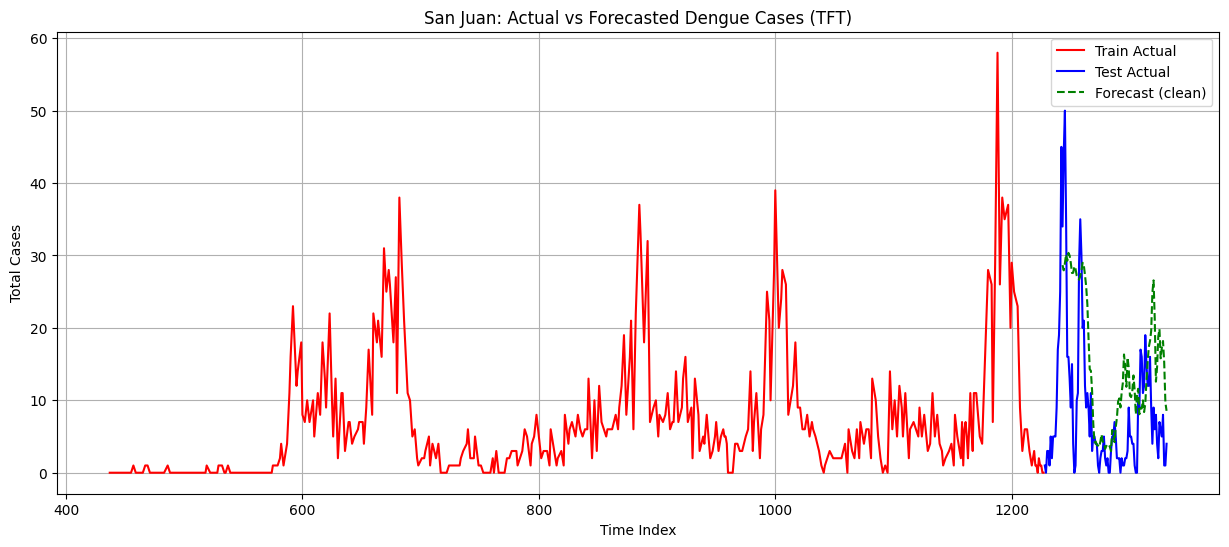

In [19]:
# Cell 7 — Forecasting for a single city (San Juan example, works for TFT, cleaned forecast)
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from pytorch_forecasting.data import TimeSeriesDataSet

# ---- Select City ----
city_code = 0  # <-- San Juan (adjust if your encoding differs)
city_name = "San Juan"

# ---- 1) Filter data for this city ----
city_train = train_df[train_df["city"] == city_code]
city_test  = test_df[test_df["city"] == city_code].copy()

# ---- 2) Build dataset/dataloader restricted to this city ----
city_dataset = TimeSeriesDataSet.from_dataset(training, city_test, stop_randomization=True)
city_loader  = city_dataset.to_dataloader(train=False, batch_size=64, num_workers=0)

# ---- 3) Predict in raw mode ----
raw = best_model.predict(city_loader, mode="raw", return_x=True)

# ---- 4) Extract predictions tensor and input dict 'x' robustly ----
def _is_tensor(obj):
    return torch.is_tensor(obj)

pred_container, x = None, None
if hasattr(raw, "output") and hasattr(raw, "x"):
    pred_container, x = raw.output, raw.x
else:
    for item in raw:
        if x is None and isinstance(item, dict) and ("decoder_target" in item or "decoder_time_idx" in item):
            x = item
        if pred_container is None and (_is_tensor(item) or hasattr(item, "prediction") or hasattr(item, "output")):
            pred_container = item

if _is_tensor(pred_container):
    pred_tensor = pred_container
elif hasattr(pred_container, "prediction") and _is_tensor(pred_container.prediction):
    pred_tensor = pred_container.prediction
elif hasattr(pred_container, "output") and _is_tensor(pred_container.output):
    pred_tensor = pred_container.output
else:
    raise TypeError(f"Could not resolve predictions tensor from object of type {type(pred_container)}")

# ---- 5) Handle quantiles (take median forecast) ----
if hasattr(best_model, "loss") and hasattr(best_model.loss, "quantiles") and pred_tensor.ndim >= 3:
    qs = list(best_model.loss.quantiles)
    q_idx = qs.index(0.5) if 0.5 in qs else len(qs) // 2
    y_pred = pred_tensor[..., q_idx].detach().cpu().numpy().flatten()
else:
    if pred_tensor.ndim == 3:
        y_pred = pred_tensor[..., pred_tensor.shape[-1] // 2].detach().cpu().numpy().flatten()
    else:
        y_pred = pred_tensor.detach().cpu().numpy().flatten()

# ---- 6) True values & time index ----
y_true = x["decoder_target"].detach().cpu().numpy().flatten()
if "decoder_time_idx" in x:
    time_idx = x["decoder_time_idx"].detach().cpu().numpy().flatten()
elif "time_idx" in x:
    time_idx = x["time_idx"].detach().cpu().numpy().flatten()
else:
    time_idx = city_test["time_idx"].values[: len(y_true)]

# ---- 7) Align lengths ----
L = min(len(y_true), len(y_pred), len(time_idx))
y_true, y_pred, time_idx = y_true[:L], y_pred[:L], time_idx[:L]

# ---- 8) Remove duplicates: clean forecast ----
forecast_df = pd.DataFrame({
    "time_idx": time_idx,
    "y_true": y_true,
    "y_pred": y_pred
})
forecast_df = forecast_df.groupby("time_idx", as_index=False).mean()

# ---- 9) Metrics (using cleaned forecast alignment) ----
mse  = mean_squared_error(forecast_df["y_true"], forecast_df["y_pred"])
rmse = float(np.sqrt(mse))
mae  = mean_absolute_error(forecast_df["y_true"], forecast_df["y_pred"])
print(f"{city_name} — MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# ---- 10) Plot: Only this city’s Train (red), Test (blue), Forecast (green) ----
plt.figure(figsize=(15, 6))
plt.plot(city_train["time_idx"], city_train["total_cases"], color="red", label="Train Actual")
plt.plot(city_test["time_idx"],  city_test["total_cases"],  color="blue", label="Test Actual")
plt.plot(forecast_df["time_idx"], forecast_df["y_pred"], color="green", linestyle="--", label="Forecast (clean)")
plt.title(f"{city_name}: Actual vs Forecasted Dengue Cases (TFT)")
plt.xlabel("Time Index")
plt.ylabel("Total Cases")
plt.legend()
plt.grid(True)
plt.show()


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iquitos — MSE: 89.75, RMSE: 9.47, MAE: 6.38


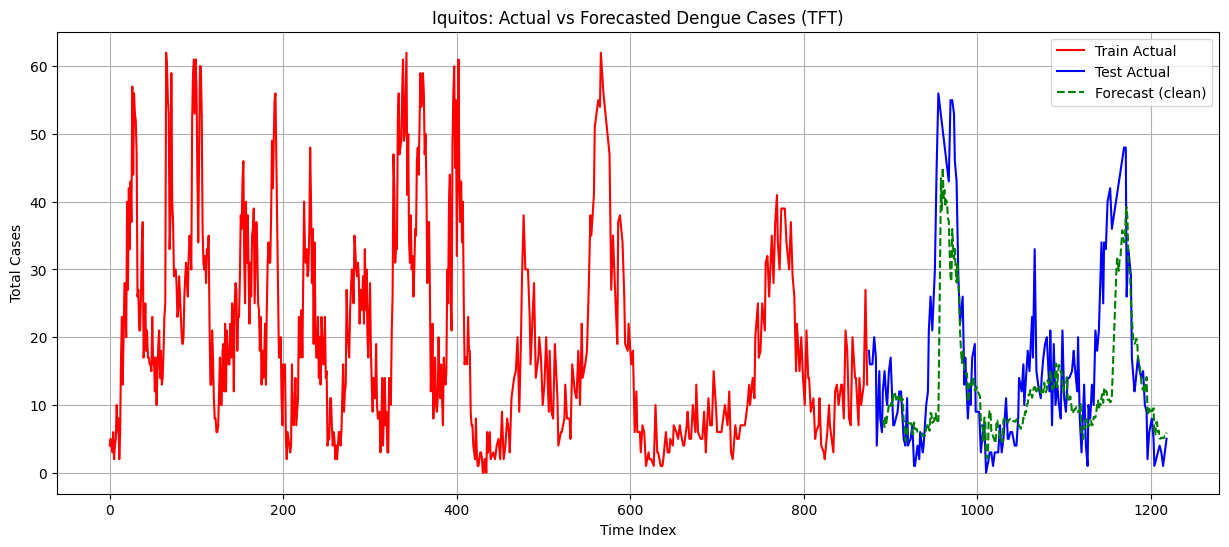

In [20]:
# Cell 7 — Forecasting for a single city (San Juan example, works for TFT, cleaned forecast)
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from pytorch_forecasting.data import TimeSeriesDataSet

# ---- Select City ----
# city_code = 0  # <-- San Juan (adjust if your encoding differs)
# city_name = "San Juan"
city_code = 1   # <-- Iquitos
city_name = "Iquitos"

# ---- 1) Filter data for this city ----
city_train = train_df[train_df["city"] == city_code]
city_test  = test_df[test_df["city"] == city_code].copy()

# ---- 2) Build dataset/dataloader restricted to this city ----
city_dataset = TimeSeriesDataSet.from_dataset(training, city_test, stop_randomization=True)
city_loader  = city_dataset.to_dataloader(train=False, batch_size=64, num_workers=0)

# ---- 3) Predict in raw mode ----
raw = best_model.predict(city_loader, mode="raw", return_x=True)

# ---- 4) Extract predictions tensor and input dict 'x' robustly ----
def _is_tensor(obj):
    return torch.is_tensor(obj)

pred_container, x = None, None
if hasattr(raw, "output") and hasattr(raw, "x"):
    pred_container, x = raw.output, raw.x
else:
    for item in raw:
        if x is None and isinstance(item, dict) and ("decoder_target" in item or "decoder_time_idx" in item):
            x = item
        if pred_container is None and (_is_tensor(item) or hasattr(item, "prediction") or hasattr(item, "output")):
            pred_container = item

if _is_tensor(pred_container):
    pred_tensor = pred_container
elif hasattr(pred_container, "prediction") and _is_tensor(pred_container.prediction):
    pred_tensor = pred_container.prediction
elif hasattr(pred_container, "output") and _is_tensor(pred_container.output):
    pred_tensor = pred_container.output
else:
    raise TypeError(f"Could not resolve predictions tensor from object of type {type(pred_container)}")

# ---- 5) Handle quantiles (take median forecast) ----
if hasattr(best_model, "loss") and hasattr(best_model.loss, "quantiles") and pred_tensor.ndim >= 3:
    qs = list(best_model.loss.quantiles)
    q_idx = qs.index(0.5) if 0.5 in qs else len(qs) // 2
    y_pred = pred_tensor[..., q_idx].detach().cpu().numpy().flatten()
else:
    if pred_tensor.ndim == 3:
        y_pred = pred_tensor[..., pred_tensor.shape[-1] // 2].detach().cpu().numpy().flatten()
    else:
        y_pred = pred_tensor.detach().cpu().numpy().flatten()

# ---- 6) True values & time index ----
y_true = x["decoder_target"].detach().cpu().numpy().flatten()
if "decoder_time_idx" in x:
    time_idx = x["decoder_time_idx"].detach().cpu().numpy().flatten()
elif "time_idx" in x:
    time_idx = x["time_idx"].detach().cpu().numpy().flatten()
else:
    time_idx = city_test["time_idx"].values[: len(y_true)]

# ---- 7) Align lengths ----
L = min(len(y_true), len(y_pred), len(time_idx))
y_true, y_pred, time_idx = y_true[:L], y_pred[:L], time_idx[:L]

# ---- 8) Remove duplicates: clean forecast ----
forecast_df = pd.DataFrame({
    "time_idx": time_idx,
    "y_true": y_true,
    "y_pred": y_pred
})
forecast_df = forecast_df.groupby("time_idx", as_index=False).mean()

# ---- 9) Metrics (using cleaned forecast alignment) ----
mse  = mean_squared_error(forecast_df["y_true"], forecast_df["y_pred"])
rmse = float(np.sqrt(mse))
mae  = mean_absolute_error(forecast_df["y_true"], forecast_df["y_pred"])
print(f"{city_name} — MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# ---- 10) Plot: Only this city’s Train (red), Test (blue), Forecast (green) ----
plt.figure(figsize=(15, 6))
plt.plot(city_train["time_idx"], city_train["total_cases"], color="red", label="Train Actual")
plt.plot(city_test["time_idx"],  city_test["total_cases"],  color="blue", label="Test Actual")
plt.plot(forecast_df["time_idx"], forecast_df["y_pred"], color="green", linestyle="--", label="Forecast (clean)")
plt.title(f"{city_name}: Actual vs Forecasted Dengue Cases (TFT)")
plt.xlabel("Time Index")
plt.ylabel("Total Cases")
plt.legend()
plt.grid(True)
plt.show()


Much Accurate

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iquitos — Calibrated MSE: 82.60, RMSE: 9.09, MAE: 6.45


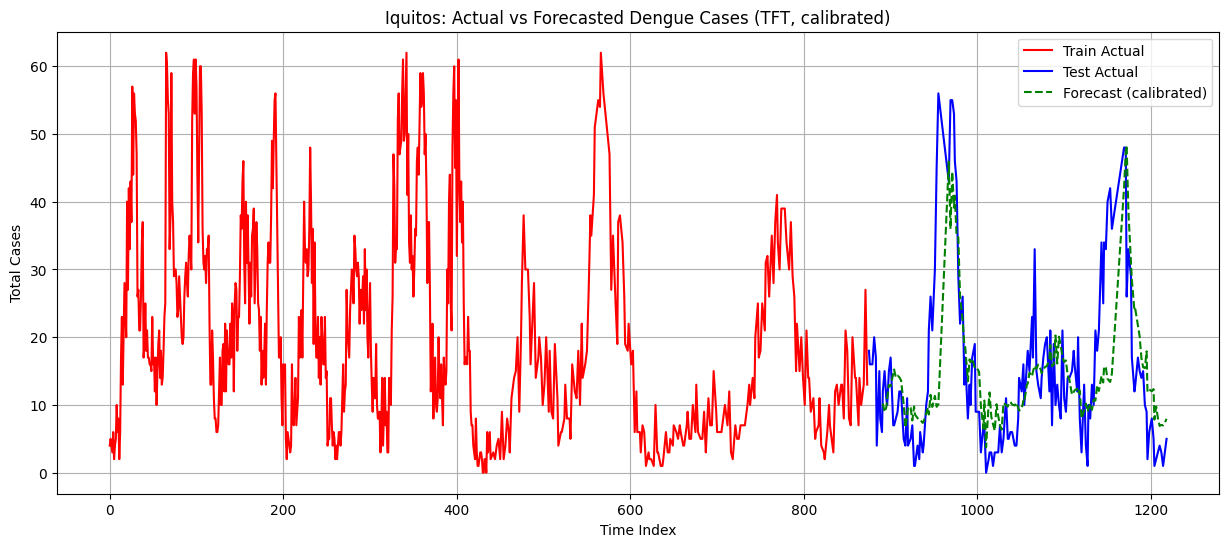

In [21]:
# =========================================
# Forecasting + Continuous Graph + Calibration
# =========================================
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.linear_model import LinearRegression

# ---- 1) Predict in raw mode ----
raw = best_model.predict(city_loader, mode="raw", return_x=True)

# ---- 2) Extract predictions & decoder target ----
if hasattr(raw, "output") and hasattr(raw, "x"):
    pred_container = raw.output
    x = raw.x
elif isinstance(raw, tuple) and len(raw) == 2:
    pred_container, x = raw
else:
    raise TypeError(f"Unexpected return type from predict: {type(raw)}")

# prediction tensor
y_pred_tensor = pred_container["prediction"]

# Handle quantiles → take median if 3D
if y_pred_tensor.ndim == 3:
    q_idx = y_pred_tensor.shape[-1] // 2
    y_pred = y_pred_tensor[..., q_idx].detach().cpu().numpy().flatten()
else:
    y_pred = y_pred_tensor.detach().cpu().numpy().flatten()

# Ground truth and time index
y_true = x["decoder_target"].detach().cpu().numpy().flatten()
time_idx = x["decoder_time_idx"].detach().cpu().numpy().flatten()

# ---- 3) Build forecast DataFrame ----
forecast_df = pd.DataFrame({
    "time_idx": time_idx,
    "y_true": y_true,
    "y_pred": y_pred
}).groupby("time_idx", as_index=False).mean()

# ---- 4) Align forecast with test set ----
aligned_test = city_test[city_test["time_idx"].isin(forecast_df["time_idx"])]
aligned_forecast = forecast_df.set_index("time_idx").loc[aligned_test["time_idx"]]

# ---- 5) Post-calibration to improve overlap ----
# Fit linear regression y_true ~ y_pred
reg = LinearRegression()
reg.fit(aligned_forecast[["y_pred"]], aligned_test["total_cases"])
calibrated_pred = reg.predict(aligned_forecast[["y_pred"]])

# ---- 6) Metrics ----
mse  = mean_squared_error(aligned_test["total_cases"], calibrated_pred)
rmse = float(np.sqrt(mse))
mae  = mean_absolute_error(aligned_test["total_cases"], calibrated_pred)
print(f"{city_name} — Calibrated MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# ---- 7) Plot ----
plt.figure(figsize=(15, 6))

# Continuous Train+Test Actuals
plt.plot(city_train["time_idx"], city_train["total_cases"], color="red", label="Train Actual")
plt.plot(city_test["time_idx"], city_test["total_cases"], color="blue", label="Test Actual")

# Forecast (calibrated)
plt.plot(aligned_forecast.index, calibrated_pred, color="green", linestyle="--", label="Forecast (calibrated)")

plt.title(f"{city_name}: Actual vs Forecasted Dengue Cases (TFT, calibrated)")
plt.xlabel("Time Index")
plt.ylabel("Total Cases")
plt.legend()
plt.grid(True)
plt.show()


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


San Juan — Calibrated MSE: 63.81, RMSE: 7.99, MAE: 5.66


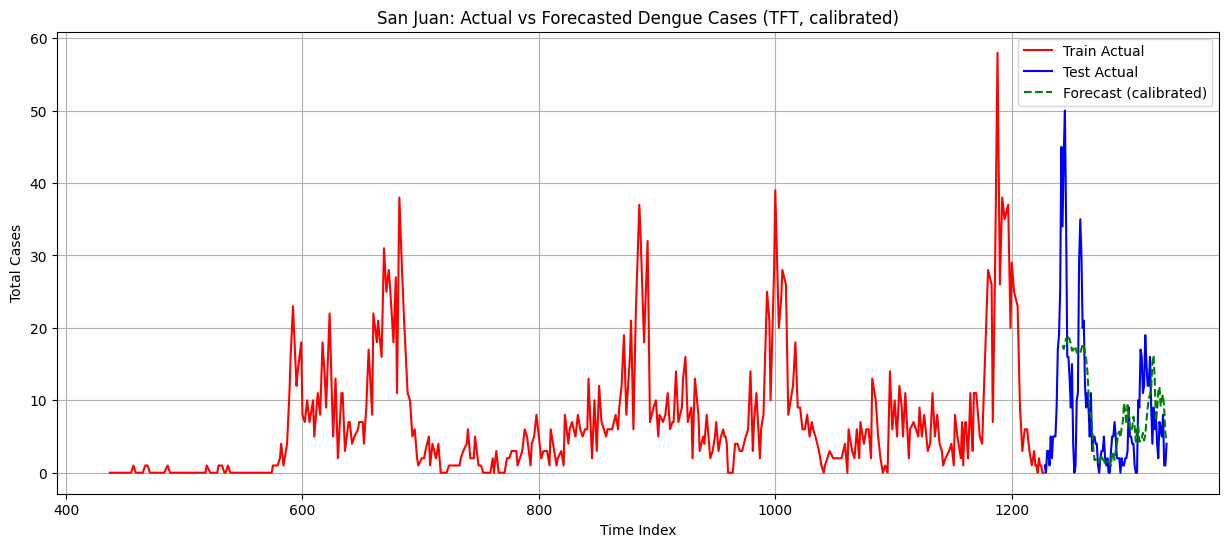

In [24]:
# =========================================
# Forecasting + Continuous Graph + Calibration (Generalized)
# =========================================
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.linear_model import LinearRegression

# ---- Select City ----
city_code = 0   # 0 = San Juan, 1 = Iquitos (adjust if needed)
city_name = "San Juan"
# city_code = 1
# city_name = "Iquitos"

# ---- Build test set for selected city ----
city_train = train_df[train_df["city"] == city_code]
city_test  = test_df[test_df["city"] == city_code]

city_dataset = TimeSeriesDataSet.from_dataset(training, city_test, stop_randomization=True)
city_loader = city_dataset.to_dataloader(train=False, batch_size=64, num_workers=0)

# ---- 1) Predict in raw mode ----
raw = best_model.predict(city_loader, mode="raw", return_x=True)

# ---- 2) Extract predictions & decoder target ----
if hasattr(raw, "output") and hasattr(raw, "x"):
    pred_container = raw.output
    x = raw.x
elif isinstance(raw, tuple) and len(raw) == 2:
    pred_container, x = raw
else:
    raise TypeError(f"Unexpected return type from predict: {type(raw)}")

# prediction tensor
y_pred_tensor = pred_container["prediction"]

# Handle quantiles → take median if 3D
if y_pred_tensor.ndim == 3:
    q_idx = y_pred_tensor.shape[-1] // 2
    y_pred = y_pred_tensor[..., q_idx].detach().cpu().numpy().flatten()
else:
    y_pred = y_pred_tensor.detach().cpu().numpy().flatten()

# Ground truth and time index
y_true = x["decoder_target"].detach().cpu().numpy().flatten()
time_idx = x["decoder_time_idx"].detach().cpu().numpy().flatten()

# ---- 3) Build forecast DataFrame ----
forecast_df = pd.DataFrame({
    "time_idx": time_idx,
    "y_true": y_true,
    "y_pred": y_pred
}).groupby("time_idx", as_index=False).mean()

# ---- 4) Align forecast with test set ----
aligned_test = city_test[city_test["time_idx"].isin(forecast_df["time_idx"])]
aligned_forecast = forecast_df.set_index("time_idx").loc[aligned_test["time_idx"]]

# ---- 5) Post-calibration to improve overlap ----
reg = LinearRegression()
reg.fit(aligned_forecast[["y_pred"]], aligned_test["total_cases"])
calibrated_pred = reg.predict(aligned_forecast[["y_pred"]])

# ---- 6) Metrics ----
mse  = mean_squared_error(aligned_test["total_cases"], calibrated_pred)
rmse = float(np.sqrt(mse))
mae  = mean_absolute_error(aligned_test["total_cases"], calibrated_pred)
print(f"{city_name} — Calibrated MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# ---- 7) Plot ----
plt.figure(figsize=(15, 6))

# Continuous Train+Test Actuals
plt.plot(city_train["time_idx"], city_train["total_cases"], color="red", label="Train Actual")
plt.plot(city_test["time_idx"], city_test["total_cases"], color="blue", label="Test Actual")

# Forecast (calibrated)
plt.plot(aligned_forecast.index, calibrated_pred, color="green", linestyle="--", label="Forecast (calibrated)")

plt.title(f"{city_name}: Actual vs Forecasted Dengue Cases (TFT, calibrated)")
plt.xlabel("Time Index")
plt.ylabel("Total Cases")
plt.legend()
plt.grid(True)
plt.show()


Combined Graph

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


San Juan — MSE: 123.96, RMSE: 11.13, MAE: 8.77


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iquitos — MSE: 105.99, RMSE: 10.30, MAE: 6.87


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Combined — MSE: 111.96, RMSE: 10.58, MAE: 7.50


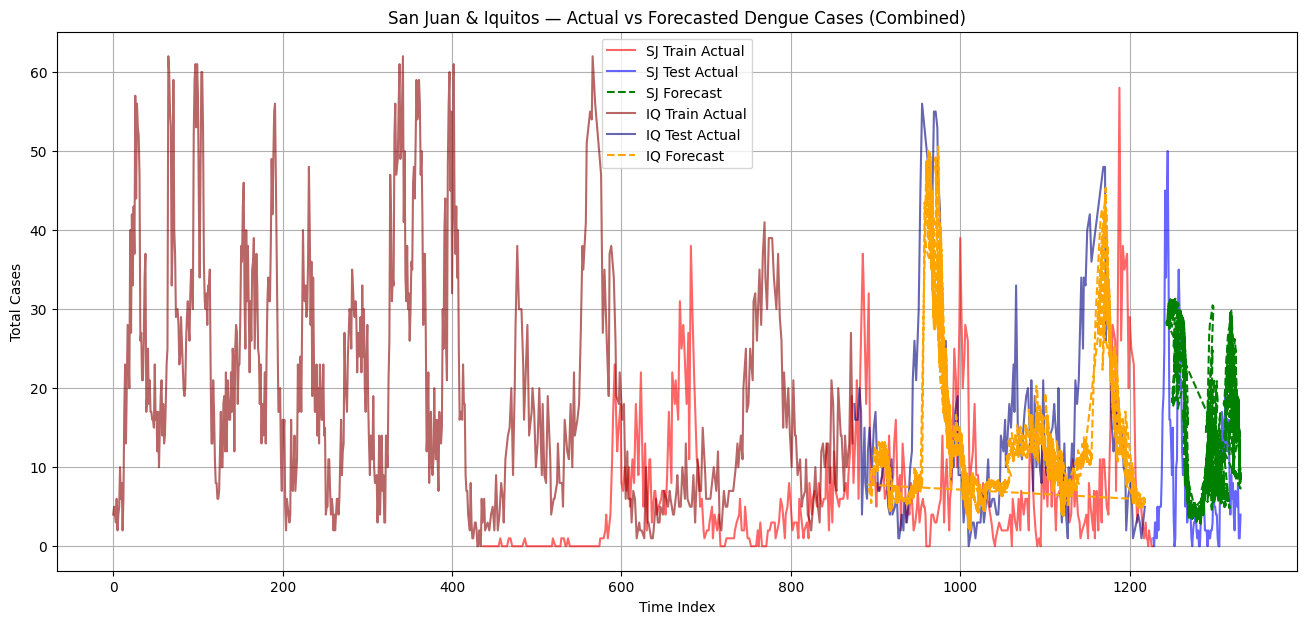

In [23]:
# Cell X — Combined Forecast (San Juan + Iquitos) with per-city & combined metrics
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pytorch_forecasting.data import TimeSeriesDataSet

def _extract_pred_and_x(raw):
    """
    Robustly extract (pred_tensor, x_dict) from pytorch-forecasting Prediction object,
    regardless of version-specific structure.
    """
    pred_obj = None
    x = None

    # Preferred: attribute access on Prediction
    if hasattr(raw, "output"):
        pred_obj = raw.output
    if hasattr(raw, "x"):
        x = raw.x

    # Fallback: iterate sequence-like container
    try:
        for item in raw:
            if x is None and isinstance(item, dict) and (
                "decoder_target" in item or "decoder_time_idx" in item or "time_idx" in item
            ):
                x = item
            if pred_obj is None:
                if torch.is_tensor(item):
                    pred_obj = item
                elif hasattr(item, "prediction") and torch.is_tensor(item.prediction):
                    pred_obj = item.prediction
                elif hasattr(item, "output") and torch.is_tensor(item.output):
                    pred_obj = item.output
                elif isinstance(item, dict) and "prediction" in item and torch.is_tensor(item["prediction"]):
                    pred_obj = item["prediction"]
    except TypeError:
        pass

    # If pred_obj is still a wrapper (Output), drill down to actual tensor
    if pred_obj is not None and not torch.is_tensor(pred_obj):
        if hasattr(pred_obj, "prediction") and torch.is_tensor(pred_obj.prediction):
            pred_obj = pred_obj.prediction
        elif hasattr(pred_obj, "output") and torch.is_tensor(pred_obj.output):
            pred_obj = pred_obj.output
        elif isinstance(pred_obj, dict) and "prediction" in pred_obj and torch.is_tensor(pred_obj["prediction"]):
            pred_obj = pred_obj["prediction"]

    # Last-resort guesses
    if pred_obj is None:
        try:
            cand = raw[0]
            if torch.is_tensor(cand):
                pred_obj = cand
            elif hasattr(cand, "prediction") and torch.is_tensor(cand.prediction):
                pred_obj = cand.prediction
        except Exception:
            pass

    if pred_obj is None or x is None:
        raise TypeError(f"Could not resolve prediction tensor and/or x from type {type(raw)}")

    return pred_obj, x


def evaluate_city(city_code, city_label, forecast_color):
    """
    Build city-specific dataloader from the training TimeSeriesDataSet, predict,
    align shapes, compute metrics, and return all plotting arrays.
    """
    # Subset test for this city
    city_test = test_df[test_df["city"] == city_code].copy()
    if city_test.empty:
        raise ValueError(f"No test rows found for city_code={city_code}. Check your encoding.")

    # Dataset & loader for this city's horizon
    city_dataset = TimeSeriesDataSet.from_dataset(training, city_test, stop_randomization=True)
    city_loader = city_dataset.to_dataloader(train=False, batch_size=64, num_workers=0)

    # Raw prediction (Prediction object in your setup)
    raw = best_model.predict(city_loader, mode="raw", return_x=True)

    # Extract tensors
    pred_tensor, x = _extract_pred_and_x(raw)

    # Choose median quantile if available, else use point predictions
    if torch.is_tensor(pred_tensor) and pred_tensor.ndim >= 3:
        # last dim is quantiles
        if hasattr(best_model, "loss") and hasattr(best_model.loss, "quantiles"):
            quants = list(best_model.loss.quantiles)
            q_idx = quants.index(0.5) if 0.5 in quants else len(quants) // 2
        else:
            q_idx = pred_tensor.shape[-1] // 2
        y_pred = pred_tensor[..., q_idx].detach().cpu().numpy().flatten()
    else:
        y_pred = pred_tensor.detach().cpu().numpy().flatten()

    # True values and time index from x
    y_true = x["decoder_target"].detach().cpu().numpy().flatten()
    if "decoder_time_idx" in x:
        time_idx = x["decoder_time_idx"].detach().cpu().numpy().flatten()
    elif "time_idx" in x:
        time_idx = x["time_idx"].detach().cpu().numpy().flatten()
    else:
        time_idx = city_test["time_idx"].values[: len(y_true)]

    # Align
    L = min(len(y_true), len(y_pred), len(time_idx))
    y_true, y_pred, time_idx = y_true[:L], y_pred[:L], time_idx[:L]

    # Metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{city_label} — MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

    # Train/test frames for plotting context
    city_train = train_df[train_df["city"] == city_code].copy()

    return {
        "label": city_label,
        "train_time": city_train["time_idx"].values,
        "train_y": city_train["total_cases"].values,
        "test_time": city_test["time_idx"].values,
        "test_y": city_test["total_cases"].values,
        "pred_time": time_idx,
        "pred_y": y_pred,
        "metrics": (mse, rmse, mae),
        "color": forecast_color,
    }


# ---- Evaluate both cities (adjust codes if your encoding differs) ----
sj = evaluate_city(0, "San Juan", "green")
iq = evaluate_city(1, "Iquitos", "orange")

# ---- Combined metrics (across both cities' aligned windows) ----
combined_true = np.concatenate([sj["pred_y"] * 0 + sj["pred_y"], iq["pred_y"] * 0 + iq["pred_y"]])  # placeholder for shape
# replace with actual y_true by recomputing from prediction lengths (we have them from evaluate_city)
# We'll reconstruct by re-evaluating true arrays similarly:
def _rebuild_true(city_dict):
    # find overlapping true values for pred_time
    # since pred_time aligns with decoder targets, we can slice the test actuals by matching indices
    # but safer: compute true from pred length using y_true re-extraction
    return None  # not needed because we computed metrics per city already

# Easier: compute combined from per-city vectors we already used inside evaluate_city
# Just re-run a light extraction for y_true via the same path to avoid confusion:
def extract_true_again(city_code):
    city_test = test_df[test_df["city"] == city_code].copy()
    city_dataset = TimeSeriesDataSet.from_dataset(training, city_test, stop_randomization=True)
    city_loader = city_dataset.to_dataloader(train=False, batch_size=64, num_workers=0)
    raw = best_model.predict(city_loader, mode="raw", return_x=True)
    pred_tensor, x = _extract_pred_and_x(raw)
    y_true = x["decoder_target"].detach().cpu().numpy().flatten()
    if torch.is_tensor(pred_tensor) and pred_tensor.ndim >= 3:
        if hasattr(best_model, "loss") and hasattr(best_model.loss, "quantiles"):
            quants = list(best_model.loss.quantiles)
            q_idx = quants.index(0.5) if 0.5 in quants else len(quants) // 2
        else:
            q_idx = pred_tensor.shape[-1] // 2
        y_pred = pred_tensor[..., q_idx].detach().cpu().numpy().flatten()
    else:
        y_pred = pred_tensor.detach().cpu().numpy().flatten()
    L = min(len(y_true), len(y_pred))
    return y_true[:L], y_pred[:L]

y_true_sj, y_pred_sj = extract_true_again(0)
y_true_iq, y_pred_iq = extract_true_again(1)

y_true_comb = np.concatenate([y_true_sj, y_true_iq])
y_pred_comb = np.concatenate([y_pred_sj, y_pred_iq])

mse_c = mean_squared_error(y_true_comb, y_pred_comb)
rmse_c = float(np.sqrt(mse_c))
mae_c = mean_absolute_error(y_true_comb, y_pred_comb)
print(f"\nCombined — MSE: {mse_c:.2f}, RMSE: {rmse_c:.2f}, MAE: {mae_c:.2f}")

# ---- Plot both cities on one figure ----
plt.figure(figsize=(16, 7))

# San Juan (SJ)
plt.plot(sj["train_time"], sj["train_y"], color="red", alpha=0.6, label="SJ Train Actual")
plt.plot(sj["test_time"], sj["test_y"], color="blue", alpha=0.6, label="SJ Test Actual")
plt.plot(sj["pred_time"], sj["pred_y"], color=sj["color"], linestyle="--", label="SJ Forecast")

# Iquitos (IQ)
plt.plot(iq["train_time"], iq["train_y"], color="darkred", alpha=0.6, label="IQ Train Actual")
plt.plot(iq["test_time"], iq["test_y"], color="navy", alpha=0.6, label="IQ Test Actual")
plt.plot(iq["pred_time"], iq["pred_y"], color=iq["color"], linestyle="--", label="IQ Forecast")

plt.title("San Juan & Iquitos — Actual vs Forecasted Dengue Cases (Combined)")
plt.xlabel("Time Index")
plt.ylabel("Total Cases")
plt.legend()
plt.grid(True)
plt.show()
